In [1]:
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

num_classes = 2
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

my_new_model = Sequential()
#my_new_model = ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path)
my_new_model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
# Say not to train first layer (ResNet) model. It is already trained
my_new_model.layers[0].trainable = False


my_new_model.add(Dense(100, activation='relu'))
my_new_model.add(Dropout(0.5))

#my_new_model.add(Dense(30, activation='relu'))
#my_new_model.add(Dropout(0.5))

#my_new_model.add(Dense(10, activation='relu'))
#my_new_model.add(Dropout(0.5))


my_new_model.add(Dense(num_classes, activation='softmax'))
#my_new_model.add(Dense(num_classes, activation='sigmoid'))



my_new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 100)               204900    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 23,792,814
Trainable params: 205,102
Non-trainable params: 23,587,712
_________________________________________________________________


In [2]:
#my_new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
from tensorflow.python.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
my_new_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [3]:

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = data_generator.flow_from_directory(
        './training',
        target_size=(image_size, image_size),
        batch_size=5,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        './validation',
        target_size=(image_size, image_size),
        class_mode='categorical')

history = my_new_model.fit(
        train_generator,
        epochs = 50,
        steps_per_epoch=5,
        validation_data=validation_generator,
        validation_steps=1)

Found 62 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 0.9426 - accuracy: 0.6400 - val_loss: 0.5923 - val_accuracy: 0.5926
Epoch 2/50
5/5 [==============================] - 5s 911ms/step - loss: 1.4906 - accuracy: 0.5600 - val_loss: 0.6044 - val_accuracy: 0.5926
Epoch 3/50
5/5 [==============================] - 4s 900ms/step - loss: 1.1728 - accuracy: 0.5455 - val_loss: 1.2624 - val_accuracy: 0.4815
Epoch 4/50
5/5 [==============================] - 4s 893ms/step - loss: 1.2221 - accuracy: 0.5600 - val_loss: 0.3902 - val_accuracy: 0.7778
Epoch 5/50
5/5 [==============================] - 4s 896ms/step - loss: 1.0233 - accuracy: 0.7200 - val_loss: 1.5523 - val_accuracy: 0.5556
Epoch 6/50
5/5 [==============================] - 4s 894ms/step - loss: 1.4597 - accuracy: 0.5909 - val_loss: 0.6794 - val_accuracy: 0.5926
Epoch 7/50
5/5 [==============================] - 5s 991ms/step - loss: 0.7317 - ac

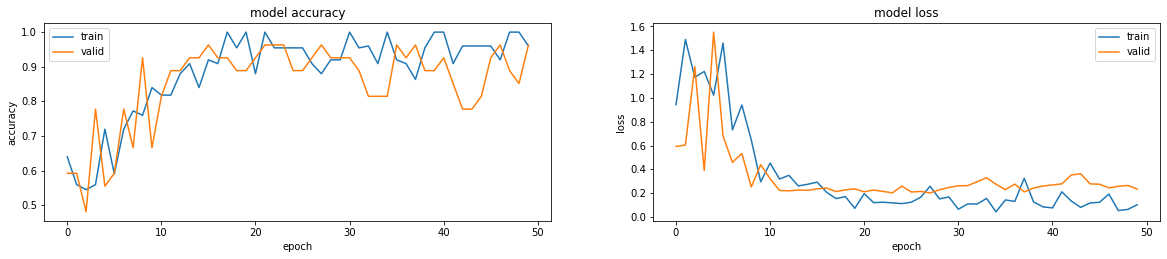

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

#import cv2
plt.figure(1, figsize = (20,8)) 
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

#### Save the model

In [5]:
my_new_model.save("model.h5")

#### Test images are kept in a single subdirectory "All". They are prefixed GOOD or BAD to check the ground truth after the model evaluates the images

In [6]:
test_generator = data_generator.flow_from_directory(
    directory = './test',
    target_size = (image_size, image_size),
    batch_size = 1,
    class_mode = None,
    shuffle = False,
    seed = 101
)

Found 16 images belonging to 2 classes.


#### Load the saved model to test the unseen samples

In [7]:
from keras.models import load_model
my_loaded_model = load_model("model.h5")
my_loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 100)               204900    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 23,792,814
Trainable params: 205,102
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
import numpy as np
test_generator.reset()

pred = my_loaded_model.predict(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

16/16 [==============================] - 2s 131ms/step


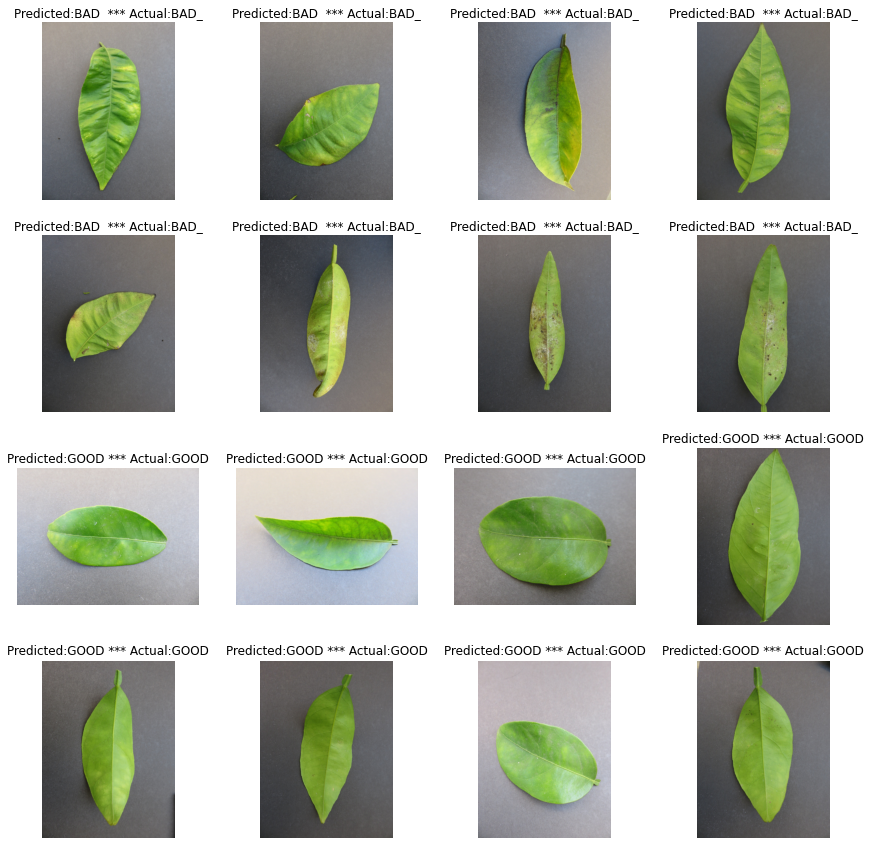

In [9]:
import cv2

TEST_DIR = './test/'
f, ax = plt.subplots(4, 4, figsize = (15, 15))

for i in range(0,16):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    fname = TEST_DIR + test_generator.filenames[i]
    aname = fname.split('/')[2].split('\\')[1][:4]
    
    
    # Good if condition else Bad
    predicted_class = "GOOD" if predicted_class_indices[i] else "BAD "

    ax[i//4, i%4].imshow(imgRGB)
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_title("Predicted:{} *** Actual:{}".format(predicted_class, aname))    

plt.show()